[nltk_data] Downloading package punkt to /Users/rohit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rohit/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /Users/rohit/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/rohit/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
/opt/homebrew/lib/python3.11/site-packages/transformers/models/auto/modeling_auto.py:1581: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Here's a concise summary:

**The Impact of Artificial Intelligence (AI) on the Future of Work:**

Artificial Intelligence is transforming the world of work, posing both opportunities and challenges for employees, employers, and society as a whole. Key implications include:

1. **Job displacement**: AI may automate certain tasks, potentially displacing jobs that involve repetitive or routine activities.
2. **New job creation**: Conversely, AI will create new job opportunities in areas like data science, machine learning engineering, and AI research.
3. **Upskilling and reskilling**: Workers will need to develop skills that complement AI's abilities, such as creativity, empathy, and complex problem-solving.
4. **Changes in work dynamics**: AI may lead to a shift from traditional 9-to-5 jobs to more flexible, project-based work arrangements.
5. **Augmented productivity**: AI can enhance human productivity by handling routine tasks, freeing up time for higher-value activities.
6. **Ethical

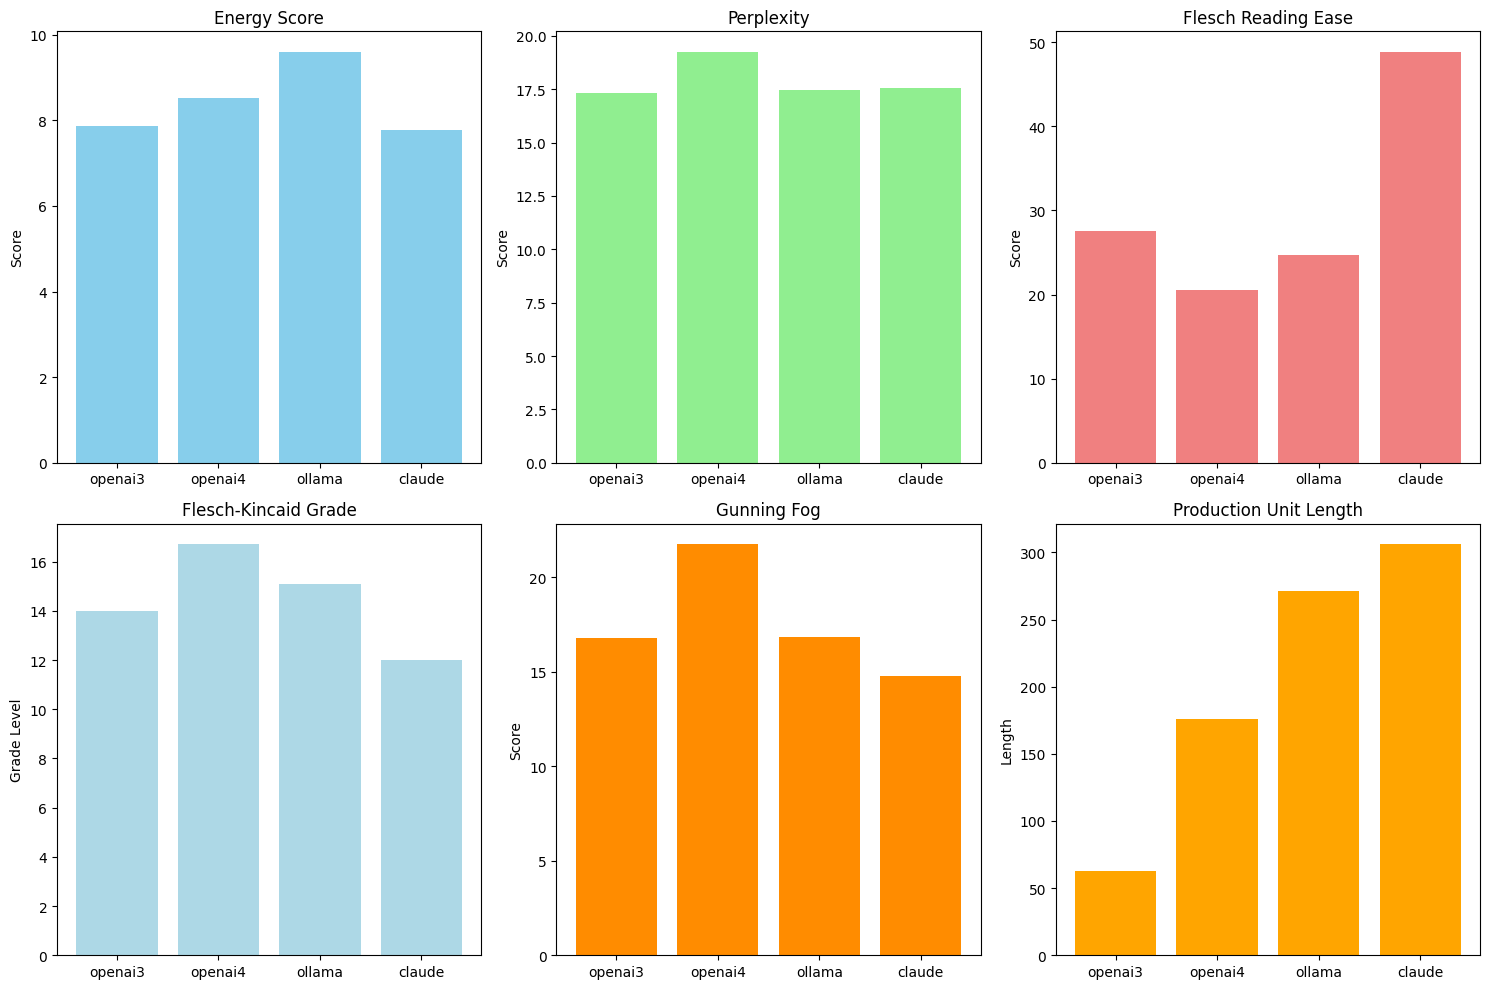

In [18]:
import os
import json
import csv
import math
from collections import Counter

import nltk
import torch
import pandas as pd
import matplotlib.pyplot as plt
import textstat
from nltk import word_tokenize, pos_tag
from nltk.corpus import brown
from tabulate import tabulate
from transformers import AutoTokenizer, AutoModelWithLMHead
from llms import llms

# Load necessary data and tools from NLTK
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('maxent_ne_chunker')

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelWithLMHead.from_pretrained("gpt2")

with open('info.json', 'r') as file:
    data = json.load(file)

instructions = data.get('instructions')
GPT4 = data.get('GPT_4')
GPT3 = data.get('GPT_MODEL')
CLAUDE = data.get('CLAUDE')
OLLAMA = data.get('OLLAMA')

# Prepare word frequencies from the Brown corpus
words_in_brown = brown.words()
freq_dict = Counter(words_in_brown)
total_words = sum(freq_dict.values())

# Enhanced grammar rule probabilities with more detailed POS patterns
rule_probs = {
    'DT NN VBZ': 0.25,  # e.g., The cat sits
    'PRP VBD DT NN': 0.15,  # e.g., I saw the dog
    'DT JJ NN VBD': 0.1,  # e.g., The quick fox jumped
    # Extend with more rules
}

def get_llm_response(input_str, llm_type='ollama'):
    if llm_type == 'openai4':
        return llms.llm_call_gpt(input_str, GPT4)
    elif llm_type == 'claude':
        return llms.llm_call_claude(input_str, CLAUDE)
    elif llm_type == 'ollama':
        return llms.llm_call_ollama(input_str, OLLAMA)
    elif llm_type == 'openai3':
        return llms.llm_call_gpt(input_str, GPT3)
    
llmcalls = ['openai3', 'openai4', 'ollama', 'claude']

responses = {}
for llmcall in llmcalls:
    response = get_llm_response("Please write a succinct summary that explains the impact of artificial intelligence on the future of work", llmcall)
    responses[llmcall] = response

def calculate_pul(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    tree = nltk.chunk.ne_chunk(tagged)
    prod_lengths = [len(prod.rhs()) for prod in tree.productions()]
    return sum(prod_lengths)

def calculate_readability_metrics(sentence):
    flesch_reading_ease = textstat.flesch_reading_ease(sentence)
    flesch_kincaid_grade = textstat.flesch_kincaid_grade(sentence)
    gunning_fog = textstat.gunning_fog(sentence)
    return flesch_reading_ease, flesch_kincaid_grade, gunning_fog

def calculate_perplexity(sentence):
    input_ids = tokenizer.encode(sentence, return_tensors="pt")
    output = model(input_ids, labels=input_ids)
    loss = output.loss
    perplexity = torch.exp(loss)
    return perplexity.item()

# Function to dynamically check grammar sequences against rule probabilities
def grammar_sequence_energy(tagged_tokens):
    grammar_energy = 0
    sequence = []
    for _, pos in tagged_tokens:
        sequence.append(pos)
        seq_str = ' '.join(sequence)
        if seq_str in rule_probs:
            grammar_energy -= math.log(rule_probs[seq_str])
            sequence = []  # Reset the sequence after matching a rule
    return grammar_energy

def sentence_energy(sentence):
    tokens = word_tokenize(sentence.lower())
    tagged = pos_tag(tokens)
    
    # Ensure we don't divide by zero if the sentence is empty
    num_tokens = max(len(tokens), 1)
    
    # Calculate word energy, modified to include normalization by sentence length
    word_energy = sum(-math.log((freq_dict.get(word, 0) + 0.01) / total_words) for word, _ in tagged) / num_tokens

    # Calculate grammar energy based on enhanced dynamic sequence matching
    grammar_energy = grammar_sequence_energy(tagged) / num_tokens

    total_energy = word_energy + grammar_energy
    return total_energy

def analyze_responses(responses):
    results = []
    for llmcall, response in responses.items():
        energy = sentence_energy(response)
        perplexity = calculate_perplexity(response)
        flesch_reading_ease, flesch_kincaid_grade, gunning_fog = calculate_readability_metrics(response)
        pul = calculate_pul(response)
        result = {
            'LLM': llmcall,
            'Response': response,
            'Energy': energy,
            'Perplexity': perplexity,
            'Flesch Reading Ease': flesch_reading_ease,
            'Flesch-Kincaid Grade': flesch_kincaid_grade,
            'Gunning Fog': gunning_fog,
            'Production Unit Length': pul
        }
        results.append(result)
    return results

results = analyze_responses(responses)
headers = list(results[0].keys())

# Generate analysis summaries
def generate_llm_summaries(results):
    analysis = []
    for result in results:
        llm_call = result['LLM']
        summary = " ".join([
            f"{llm_call} presents an energy score of {result['Energy']:.2f}, indicating a {'moderate' if result['Energy'] < 9 else 'high'} level of vibrancy.",
            f"{llm_call} has a perplexity score of {result['Perplexity']:.2f}, indicating {'good' if result['Perplexity'] < 12 else 'poor'} coherence.",
            f"{llm_call} has a Flesch Reading Ease of {result['Flesch Reading Ease']:.2f}, suggesting the text is {'challenging' if result['Flesch Reading Ease'] < 40 else 'easy'}.",
            f"{llm_call} has a Flesch-Kincaid Grade of {result['Flesch-Kincaid Grade']:.1f}, suitable for {'college-level' if result['Flesch-Kincaid Grade'] > 12 else 'high-school'} readers.",
            f"{llm_call} has a Gunning Fog index of {result['Gunning Fog']:.2f}, indicating {'complex' if result['Gunning Fog'] > 12 else 'simple'} text.",
            f"{llm_call} generated a text of length {result['Production Unit Length']}, which is {'concise' if result['Production Unit Length'] < 500 else 'detailed'}."
        ])
        result['Summary'] = summary
        analysis.append(result)
    return analysis

results_with_summaries = generate_llm_summaries(results)
df = pd.DataFrame(results_with_summaries)
df.to_csv('results_table.csv', index=False)

# Generate a bar chart for comparison
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()

chart_labels = [
    ('Energy', 'Score', 'Energy Score', 'skyblue'),
    ('Perplexity', 'Score', 'Perplexity', 'lightgreen'),
    ('Flesch Reading Ease', 'Score', 'Flesch Reading Ease', 'lightcoral'),
    ('Flesch-Kincaid Grade', 'Grade Level', 'Flesch-Kincaid Grade', 'lightblue'),
    ('Gunning Fog', 'Score', 'Gunning Fog', 'darkorange'),
    ('Production Unit Length', 'Length', 'Production Unit Length', 'orange')
]

for i, (col, ylabel, title, color) in enumerate(chart_labels):
    ax[i].bar(df['LLM'], df[col], color=color)
    ax[i].set_title(title)
    ax[i].set_ylabel(ylabel)

plt.tight_layout()
plt.savefig("llm_comparison.png")
plt.show()
